In [13]:
import glob
import scipy
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from natsort import natsorted
from scipy.stats import describe
from scipy.signal import filtfilt
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
import matplotlib
from natsort import natsorted
from scipy.sparse.linalg import svds

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', size=14) 
%config InlineBackend.figure_format = 'svg'

In [2]:
path = '/Users/patrick/Documents/phd/GitHub/tikhonov/'

In [3]:
g4iso_files = natsorted(glob.glob(path+"g4out/*KE_*_iso.csv"))

def cnum(xbinw,ebinw,num_components,preconditionl,preconditionr):
    R = []
    D = []

    for i in range(5,len(g4iso_files),ebinw): # 100 keV to 1 MeV energy range in steps of 100 keV
        R.append(np.loadtxt(open(g4iso_files[i], "r"), delimiter=",",skiprows=9)[30:2000:xbinw,3]/5000000.0)
    R = np.transpose(np.array(R))

    RR = R
    for j in range(0,R.shape[0]): # X-ray spectra from 0 to 600 keV
        if (np.linalg.norm(R[j,:] > 0)):
            D.append((1.0/np.linalg.norm(R[j,:]))) # Diagonal scaling as a left pre-conditioner
        else:
            D.append(1)

    DD = np.diag(D)
    if (preconditionl):
        RT = np.matmul(DD,R)
    else: 
        RT = R

    S = []
    for k in range(0,R.shape[1]):
        #S.append(1.0/(k+1)**2) # right pre-conditioner towards an exponential
        S.append(1.0/np.sum(R[:,k]))
        #S.append(alexa_model_exp[k])
        #S.append(1)
    SS = np.diag(S)
    
    if (preconditionr):
        RS = np.matmul(RT,SS)
    else:
        RS = RT
    return(np.linalg.cond(RS))

203.81885278866218

In [4]:
def tsvd(num_components,preconditionl,preconditionr):

    X = np.arange(10, 100, 5)
    Y = np.arange(1, 20, 1)
    XX, YY = np.meshgrid(X, Y)
    Z = []
    zm=[]
    for i in X:
        print(i)
        for j in Y:
            zm.append(cnum(i,j,num_components,preconditionl,preconditionr))
        Z.append(zm)
        zm=[]
    ZZ = np.transpose(np.array(Z))
    return([XX,YY,ZZ])

In [5]:
cnum_nopre = tsvd(1,False,False)

10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


In [6]:
cnum_leftpre = tsvd(1,True,False)

10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


In [7]:
cnum_rightpre = tsvd(1,False,True)

10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


In [8]:
cnum_bothpre = tsvd(1,True,True)

10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


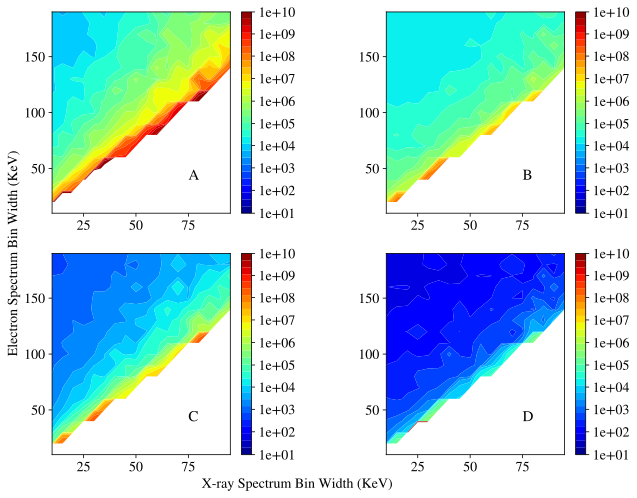

In [16]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import ticker, cm



fig = plt.figure(figsize=(10,8))
gs = plt.GridSpec(nrows=2, ncols=2,hspace=.2,wspace=.5)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])

target = cnum_nopre
cs1=ax1.contourf(target[0],target[1]*10,target[2],locator=ticker.LogLocator(),levels=np.logspace(1,10,30),cmap='jet')
cbar1=plt.colorbar(cs1,ticks=np.logspace(1,100,100),ax=ax1,format='%.0e')

target = cnum_leftpre
cs2=ax2.contourf(target[0],target[1]*10,target[2],locator=ticker.LogLocator(),levels=np.logspace(1,10,30),cmap='jet')
cbar2=plt.colorbar(cs2,ticks=np.logspace(1,100,100),ax=ax2,format='%.0e')

target = cnum_rightpre
cs3=ax3.contourf(target[0],target[1]*10,target[2],locator=ticker.LogLocator(),levels=np.logspace(1,10,30),cmap='jet')
cbar3=plt.colorbar(cs3,ticks=np.logspace(1,100,100),ax=ax3,format='%.0e')

target = cnum_bothpre
cs4=ax4.contourf(target[0],target[1]*10,target[2],locator=ticker.LogLocator(),levels=np.logspace(1,10,30),cmap='jet')
cbar4=plt.colorbar(cs4,ticks=np.logspace(1,100,100),ax=ax4,format='%.0e')


ax1.text(75, 40, 'A', fontsize=15)
ax2.text(75, 40, 'B', fontsize=15)
ax3.text(75, 40, 'C', fontsize=15)
ax4.text(75, 40, 'D', fontsize=15)

ax4.set_xlabel('X-ray Spectrum Bin Width (KeV)',x=-.5)
ax3.set_ylabel('Electron Spectrum Bin Width (KeV)',y=1)

#cbaxes = fig.add_axes([1.1, 0.1, 0.93, 0.8]) 
plt.savefig('condition_number_binning_precondition2.pdf')  
plt.show()